# Estimation of the SoftMax normalization constant

Here we show how to use the `computeZest` function of the `EDRep` package that computes the normalization constants 

$$
Z_i = \sum_{i = 1}^n e^{x_i^Tx_j}
$$

The function is called as

> ```python
> res = computeZest(X, indices, k)
> ```

where, ```X``` is an array containing in its rows the vectors $x_i$. ```indices``` is the set of indeces $i$ for which $Z_i$ has to be returned.

> **REMARK**: our estimation method can compute $Z_i$ for all indeces in parallel. In this case, one needs to set ```indices = np.arange(n)```, where ```n``` is the number of rows of ```X```.

The function features an additional parameter ```k``` which is optional and it is the order of the mixture model. The larger ```k```, the higher the accuracy, but the longer the computational time. The output of this function is a class whose elements are described as follows:


> * res.Zest (array): array containing the Z_i values corresponding to the indices
> * res.ℓ (array): label vector
> * res.μ (array of size (d x k)): it contains the mean embedding vectors for each class
> * res.Ω (list of k arrays of size (d x d)): it contains the covariance embedding matrix for each class
> * res.π (array of size k): size of each class

## Load the relevant packages

In [1]:
# load useful packages for data processing and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

# load the computeZest function from the EDRep package
from EDRep import computeZest

# in this script we implemented a competing method as a reference
from src.EstimateZ import *

## Load an embedding matrix

In the `data` folder, add a file called `0.txt`, taken from https://vectors.nlpl.eu/repository/ (the file with ID 0). We use this file to show how to use our function. Note that we perform the operation ```X = X/np.mean(norms)``` because our result holds for embedding vectors with bounded norms.

In [2]:
# load the data
X = pd.read_csv('data/0.txt', skiprows = 1, on_bad_lines='skip', sep = ' ', header = None, quoting=csv.QUOTE_NONE,
                encoding='latin-1')
X.set_index(0, inplace = True)
X = X.dropna(axis = 1)
X = X.values

# number of indeces and embedding dimensions
n, dim = np.shape(X)

# rescale the norms of the embedding vectors
norms = np.sqrt(X**2@np.ones(dim))
X = X/np.mean(norms)

## Compute the normalization constants


We compute the normalization constants for $N$ indices (and not for the full dataset) because we compare them with the exact computation which is very time-consuming. We compare our calculation with a method based on Random projections that exploits the kernel method.

In [3]:
# select some random indices
N = 3000
indices = np.random.choice(n, N, replace = False)

# exact computation
Z = np.sum(np.exp(X[indices]@X.T), axis = 1)

# EDRep
res = computeZest(X, indices, k = 1)

# RF
D = 1000
Z_RFM = RFM(X, D, indices)

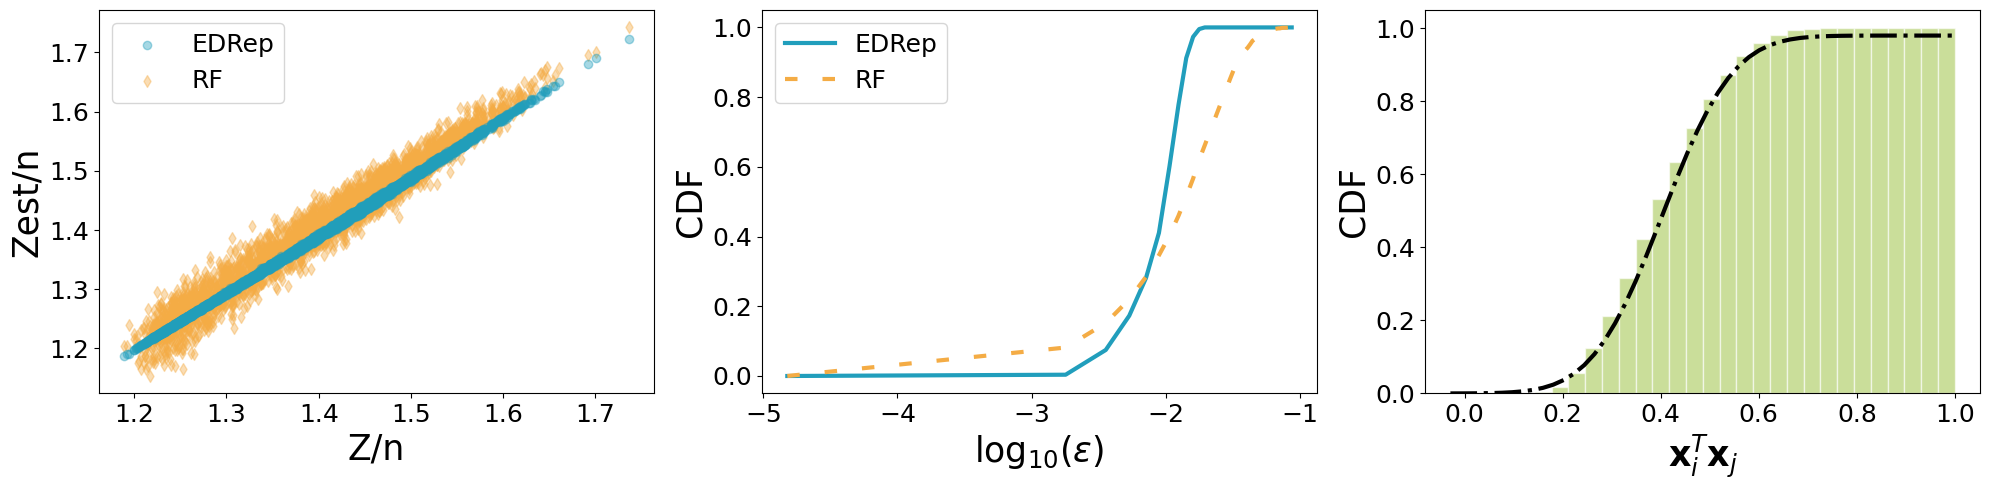

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

colors = ['#219ebc', '#F4AC45']

ls = ['-', (0, (3, 6)), (0, (1,1))]
labels = ['EDRep', 'RF']

# scatter plot of exact vs estimated Z
ax[0].scatter(Z/n, res.Zest/n, color = colors[0], alpha = 0.4, marker = 'o', zorder = 1, label = 'EDRep')
ax[0].scatter(Z/n, Z_RFM/n, alpha = 0.4, color = colors[1], marker = 'd', zorder = 0, label = 'RF')
ax[0].legend(fontsize = 18)
ax[0].set_xlabel('Z/n', fontsize = 25)
ax[0].set_ylabel('Zest/n', fontsize = 25)
ax[0].tick_params(axis='both', which='major', labelsize=18)

# CDF of the error
eps = [np.abs(Z - res.Zest)/n, np.abs(Z - Z_RFM)/n]
emin, emax = np.min(np.concatenate(eps)), np.max(np.concatenate(eps))
tv = np.linspace(np.max([-5, emin]), emax)

for i in range(len(eps)):
    ax[1].plot(np.log10(tv), [np.mean(eps[i] < t) for t in tv], color = colors[i], linewidth = 3, linestyle = ls[i], label = labels[i])
    
ax[1].set_xlabel(r'${\rm log}_{10}(\epsilon)$', fontsize = 25)
ax[1].set_ylabel('CDF', fontsize = 25)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].legend(fontsize = 18)


# fit of the scalar product distribution

# select a random index
α = np.random.randint(n)
    
ax[2].hist(X[α]@X.T, bins = 30, edgecolor = 'white', color = '#a7c957', alpha = 0.6,
                    density = True, label = 'Empirical', cumulative = True)

m = np.mean(X[α]@X.T) 
s = np.sqrt(np.var(X[α]@X.T))

t = np.linspace(1.03*np.min(X[α]@X.T), np.max(X[α]@X.T))
π, μ, σ2 = res.π, res.μ, res.Ω

y = np.sum(np.diag(π/n)@np.array([Normal(X[α]@μ[b].T, X[α]@σ2[b]@X[α], t) for b in range(len(μ))]), axis = 0)
ax[2].plot(t, np.cumsum(y)*(max(t)-min(t))/len(t), color = 'k', linewidth = 3, linestyle = '-.', label = 'mvGaussian')
ax[2].tick_params(axis='both', which='major', labelsize = 18)
ax[2].set_xlabel(r'$\mathbf{x}_i^T\mathbf{x}_j$', fontsize = 25)
ax[2].set_ylabel('CDF', fontsize = 25)


plt.tight_layout()
plt.show();